In [14]:
# Dima Oana-Teodora 241
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop

import tensorflow.compat as tf
#import tensorflow.compat.v1 as tf 
#tf.disable_v2_behavior()

from tensorflow import keras
from tensorflow.keras import layers

import csv

from sklearn.utils import shuffle

from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.layers.core import Dropout
from sklearn import metrics


In [2]:
# citire imagini de antrenare plus etichete de antrenare
f = open ("train.txt") # deschidere fisier
train_images = []
train_labels = []
for line in enumerate(open("train.txt", "r")):
    v = line[1].split(',') # citire linie din fisier
    image_name = 'train/'+v[0] # formare cale catre folderul cu imagini
    label = int(v[1]) # transformare numar clasa din string in int
    train_labels.append(label) # adaugare clasa 
    image = plt.imread(image_name) # citire imagine matrice 32 X 32
    
    image=image.reshape(-1) # din 2D => 1D
    
    train_images.append(image) # adaugare imagine
# transformare in numpy arrays
train_images = np.array(train_images) 
train_labels = np.array(train_labels) 

train_images, train_labels = shuffle(train_images, train_labels) # amestecare

In [3]:
# citire imagini de testare 
f = open ("test.txt")
test_images = []
name_test_images =[]
for line in enumerate(open("test.txt", "r")):
    image_name = 'test/'+ line[1][:len(line[1])-1] # formare cale director cu imagini 
                                                    #(+ sterg caracterul '\n' de la final, altfel => erooare)
    name_test_images.append(line[1][:len(line[1])-1])
    image = plt.imread(image_name)
    image=image.reshape(-1) # din 2D => 1D
    test_images.append(image)
    
test_images = np.array(test_images)

In [4]:
# citire imagini de validare plus etichete de validare
f = open ("validation.txt")
validation_images = []
validation_labels = []
for line in enumerate(open("validation.txt", "r")):
    v = line[1].split(',')
    image_name = 'validation/'+v[0]
    label = int(v[1])
    validation_labels.append(label)
    image = plt.imread(image_name)
    image=image.reshape(-1) # din 2D => 1D
    validation_images.append(image)

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

validation_images, validation_labels = shuffle(validation_images, validation_labels)

In [5]:
classes = 9 # 9 categorii notate de la 0 la 8

y_val=np_utils.to_categorical(validation_labels, classes) 
y_train=np_utils.to_categorical(train_labels, classes) 

In [6]:
# Marire esantion de date
# creez un esantion separat
# prin aplicarea de transformari aleatorii imaginilor de antrenament 
# Scop: evitarea overfitting-ului & expunerea modelului la mai multe cazuri de studiu  
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"), #rasucire orizontala
        layers.experimental.preprocessing.RandomRotation(0.1), #rotatie aleatorie a imaginii
    ]
)
# creare model de baza
base_model = keras.applications.Xception(
    weights="imagenet",  # incarcare date preantrenate din ImageNet
    input_shape=(150, 150, 3), #dimensiuni ImageNet
    include_top=False
)  


# "Dezactivare" model de baza (Freezing) 
base_model.trainable = False

# Craere model nou 
inputs = keras.Input(shape=(32, 32, 3)) 
x = data_augmentation(inputs)  # Aplicare transformari aleatorii 

# Adaug un layer de normalizare pe intervalele [0,255] & [-1,1] => datele preantrenate au nevoie de normalizare
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# [-1,1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# "Batch normalization" -> model mai rapid si stabil, normalizare layer de intrare (prin recentrare si redimensionare)
# Modelul de baza contine layere batch-norm 
# Pastrare model in modul de inferenta (inference mode) -> pregatirea pentru fine-tuning  
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

# Pentru regularizare adaug un Dropout layer => Scop: reducere overfitting
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [7]:
model = Sequential()
model.add(Dense(1000, input_shape =(train_images.shape[1],)))
model.add(Activation ('relu'))
model.add(Dense(200))
model.add(Activation ('sigmoid'))
model.add(Dense(classes))
model.add(Activation ('softmax'))


In [8]:
# configurare model
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6, decay=1e-6), metrics=['accuracy'])
# antrenare model
history = model.fit(train_images, y_train, batch_size=200, epochs=100, verbose=2, validation_data=(validation_images, y_val))
# evaluare model
loss_accuracy = model.evaluate(validation_images, y_val)
print(loss_accuracy)

Epoch 1/100
151/151 - 5s - loss: 0.2941 - accuracy: 0.3776 - val_loss: 0.3219 - val_accuracy: 0.3222
Epoch 2/100
151/151 - 3s - loss: 0.2414 - accuracy: 0.5156 - val_loss: 0.3670 - val_accuracy: 0.3176
Epoch 3/100
151/151 - 3s - loss: 0.2189 - accuracy: 0.5683 - val_loss: 0.4075 - val_accuracy: 0.2832
Epoch 4/100
151/151 - 3s - loss: 0.2048 - accuracy: 0.6013 - val_loss: 0.2646 - val_accuracy: 0.4932
Epoch 5/100
151/151 - 3s - loss: 0.1932 - accuracy: 0.6284 - val_loss: 0.2191 - val_accuracy: 0.5574
Epoch 6/100
151/151 - 3s - loss: 0.1837 - accuracy: 0.6484 - val_loss: 0.3870 - val_accuracy: 0.3428
Epoch 7/100
151/151 - 3s - loss: 0.1784 - accuracy: 0.6618 - val_loss: 0.3544 - val_accuracy: 0.3694
Epoch 8/100
151/151 - 3s - loss: 0.1709 - accuracy: 0.6753 - val_loss: 0.2110 - val_accuracy: 0.5900
Epoch 9/100
151/151 - 3s - loss: 0.1634 - accuracy: 0.6933 - val_loss: 0.2525 - val_accuracy: 0.5184
Epoch 10/100
151/151 - 3s - loss: 0.1575 - accuracy: 0.7079 - val_loss: 0.3625 - val_accura

Epoch 82/100
151/151 - 4s - loss: 0.0185 - accuracy: 0.9754 - val_loss: 0.2170 - val_accuracy: 0.7688
Epoch 83/100
151/151 - 4s - loss: 0.0203 - accuracy: 0.9726 - val_loss: 0.2802 - val_accuracy: 0.6988
Epoch 84/100
151/151 - 5s - loss: 0.0190 - accuracy: 0.9743 - val_loss: 0.2788 - val_accuracy: 0.7190
Epoch 85/100
151/151 - 5s - loss: 0.0183 - accuracy: 0.9759 - val_loss: 0.2305 - val_accuracy: 0.7564
Epoch 86/100
151/151 - 4s - loss: 0.0174 - accuracy: 0.9773 - val_loss: 0.2554 - val_accuracy: 0.7316
Epoch 87/100
151/151 - 4s - loss: 0.0183 - accuracy: 0.9761 - val_loss: 0.2574 - val_accuracy: 0.7262
Epoch 88/100
151/151 - 4s - loss: 0.0191 - accuracy: 0.9753 - val_loss: 0.2469 - val_accuracy: 0.7422
Epoch 89/100
151/151 - 4s - loss: 0.0204 - accuracy: 0.9749 - val_loss: 0.2270 - val_accuracy: 0.7648
Epoch 90/100
151/151 - 4s - loss: 0.0181 - accuracy: 0.9770 - val_loss: 0.2204 - val_accuracy: 0.7652
Epoch 91/100
151/151 - 4s - loss: 0.0159 - accuracy: 0.9788 - val_loss: 0.2479 - v

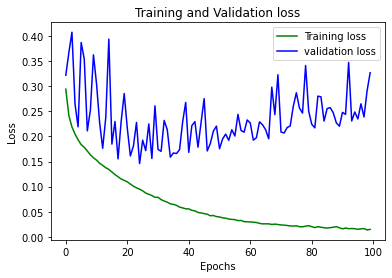

In [11]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(100)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

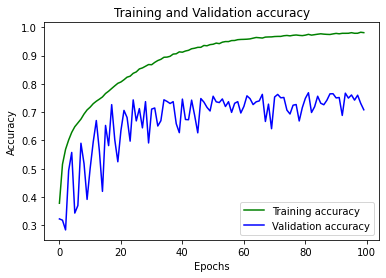

In [12]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(100)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# prezic clasele pe imaginile de validare
y_pred=model.predict_classes(validation_images).astype("int32")
# calcul matrice de confuzie
confusion_matrix=metrics.confusion_matrix(validation_labels, y_pred, labels=[0,1,2,3,4,5,6,7,8])
#print(confusion_matrix)

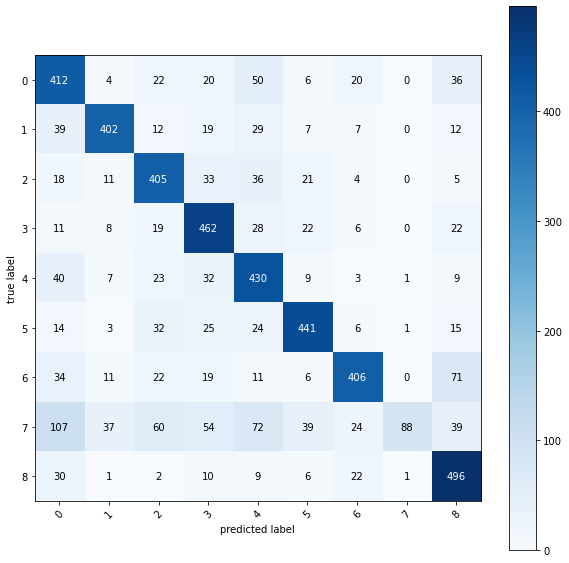

In [16]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix, colorbar=True, 
                      class_names=[0,1,2,3,4,5,6,7,8], 
                      figsize=(10, 10))
plt.show()

In [17]:
# prezicere
predict = model.predict_classes(test_images).astype("int32")

# scriere in fisier 
f = open("submission_2.csv", "w", newline="")
csv_file= csv.writer(f, delimiter=",") #stabilire delimitatori cuvinte
csv_file.writerow(['id', 'label']) # capul de tabel
for i in range (predict.shape[0]):
    csv_file.writerow([name_test_images[i], predict[i]])
f.close()